In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *
from ourworldindata_org.collector import *

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch data set from local disk

In [4]:
!ls ~/data/
# gets thte latest file names
recent = ! ls -drt ~/data/* | tail -n 2
print("Latest files are:\n\t{}\n\t{}".format(*recent))

2020-04-07_2224_state_daily_data.csv 2020-04-07_2224_state_rank.csv
Latest files are:
	/Users/drskippy/data/2020-04-07_2224_state_daily_data.csv
	/Users/drskippy/data/2020-04-07_2224_state_rank.csv


In [5]:
df, states_in_order = get_dataset_df_from_file(recent)
df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,tests,posNeg,fips,daily_new_death,hospitalizedIncrease,negativeIncrease,daily_new_positive,totalTestResultsIncrease,order,last_update
0,2020-03-04,NY,6.0,48.0,24.0,NaN,NaN,NaN,NaN,NaN,...,54,54,36,NaN,NaN,NaN,NaN,NaN,0,2020-04-06
1,2020-03-05,NY,22.0,76.0,24.0,NaN,NaN,NaN,NaN,NaN,...,98,98,36,0.0,0.0,28.0,16.0,44.0,0,2020-04-06
2,2020-03-06,NY,33.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,...,125,125,36,0.0,0.0,16.0,11.0,27.0,0,2020-04-06
3,2020-03-07,NY,76.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,...,168,168,36,0.0,0.0,0.0,43.0,43.0,0,2020-04-06
4,2020-03-08,NY,105.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,...,197,197,36,0.0,0.0,0.0,29.0,29.0,0,2020-04-06


### SIR Model

In [6]:
dfq = get_state_df(df, "*")
cc = CurrentCasesUndercount()
dfq = cc.add_positive_estimate(dfq)
ccd = CurrentCasesFromDeaths()
dfq = ccd.add_positive_estimate(dfq)
dfq.head()

,date,positive,daily_new_positive,death,daily_new_death,tests,daily_new_positive_undercount,positive_undercount,daily_new_positive_fromdeath,positive_fromdeath
0,2020-03-04,118.0,0.0,10.0,0.0,866,0.0,0.0,0.0,7800.0
1,2020-03-05,176.0,55.0,11.0,1.0,1129,99.0,99.0,200.0,10000.0
2,2020-03-06,223.0,44.0,14.0,3.0,1794,79.2,178.2,600.0,12200.0
3,2020-03-07,341.0,113.0,16.0,2.0,2150,203.4,381.6,400.0,16000.0
4,2020-03-08,417.0,76.0,18.0,2.0,2752,136.8,518.4,400.0,20400.0


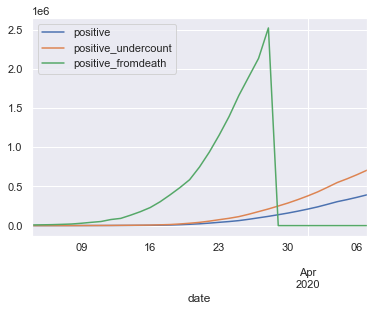

In [7]:
dfq.plot(x="date", y=["positive", "positive_undercount", "positive_fromdeath"])

### SIR Fit

   direc: array([[-1.00830273e-03,  7.98923220e-04,  1.52653094e-01],
       [-2.28382943e-04,  1.62376186e-06,  1.66251101e-03],
       [-3.11815035e-04,  3.01846148e-04,  8.68139130e-02]])
     fun: 24705.796695957986
 message: 'Optimization terminated successfully.'
    nfev: 321
     nit: 8
  status: 0
 success: True
       x: array([0.2476231 , 0.11515451, 4.46533795])
Day 0 = 2020-03-04 00:00:00  (today=34)
Doubling time is about 2.80 days
Recovery time is about 6.02 days
Estimated initial infection was order of 4,465 poeple


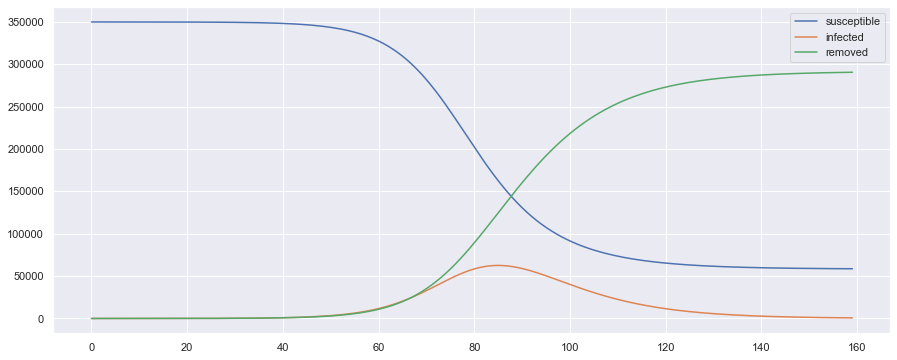

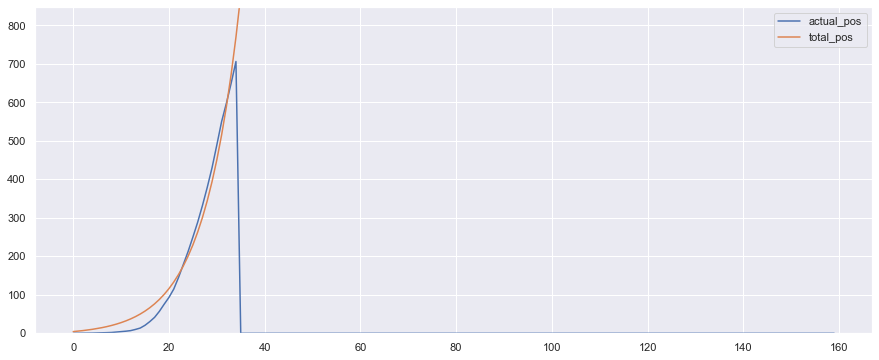

In [8]:
N=350000 
x0 = (0.25749545, 0.10952173, 3.17810689)  # beta, gamma, I0
c = cc.fit_series/1000
sf = SIR()
beta, gamma, I0 = sf.SIRFitter(c, N, x0)
print("Day 0 = {}  (today={})".format(dfq.date.values[0] - pd.Timedelta(days=cc.shift),
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))

   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: 110156.14299548426
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 2
  status: 0
 success: True
       x: array([0.29275483, 0.10963222, 3.1809029 ])
Day 0 = 2020-02-23 00:00:00  (today=44)
Doubling time is about 2.37 days
Recovery time is about 6.32 days
Estimated initial infection was order of 3,180 poeple


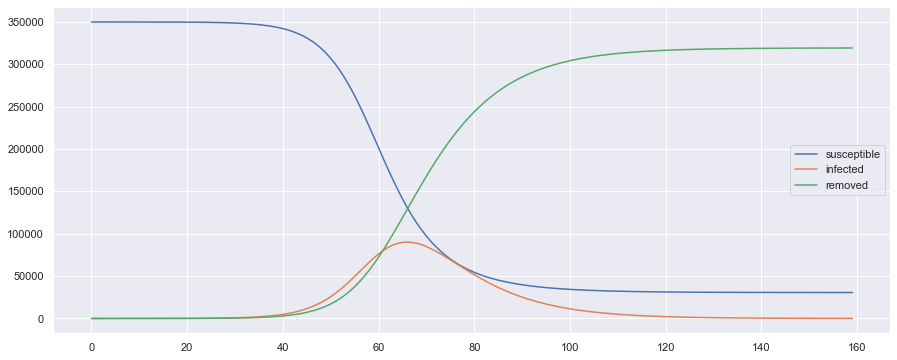

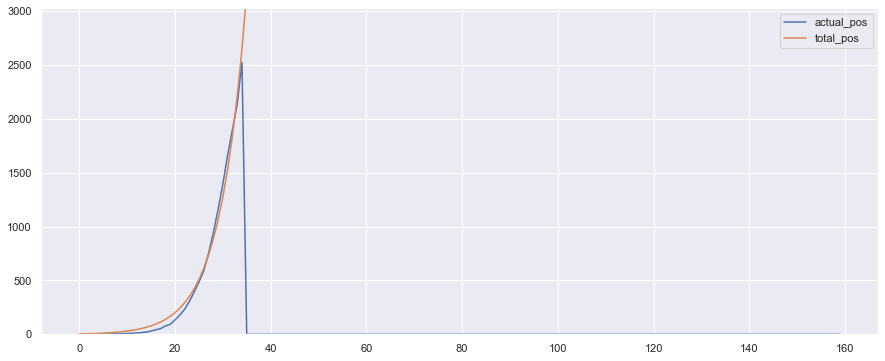

In [9]:
N=350000 
x0 = (0.25749545, 0.10952173, 3.17810689)  # beta, gamma, I0
c = ccd.fit_series/1000
sf = SIR()
beta, gamma, I0 = sf.SIRFitter(c, N, x0)
print("Day 0 = {}  (today={})".format(dfq.date.values[0] - pd.Timedelta(days=ccd.shift),
                            (pd.Timestamp.now() - dfq.date.values[0]).days + ccd.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))

### SIR4: Try Varying beta as part of the model

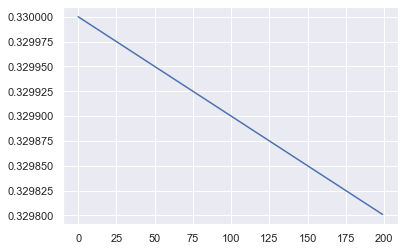

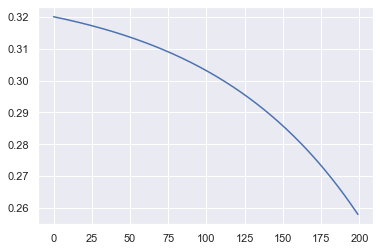

In [10]:
def g(alpha, beta0, t):
    return beta0 - alpha * t

def h(alpha, beta0, t):
    return beta0 - np.log(alpha) * alpha ** t

t = np.arange(0, 200, 1)
plt.plot(t, g(.000001, .33, t))
plt.show()
plt.plot(t, h(1.01, .33, t))
plt.show()

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[-9.26796679e-04,  2.76195296e-03,  2.34742469e-04,
        -2.90586942e-02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-2.59381826e-05,  8.67598885e-05,  3.49882715e-06,
        -6.33853247e-04]])
     fun: 15675.94024400818
 message: 'Optimization terminated successfully.'
    nfev: 825
     nit: 12
  status: 0
 success: True
       x: array([0.02356452, 0.82538053, 0.12059688, 0.12045219])
Day 0 = 2020-02-23 00:00:00  (today=44)
Doubling time (0) is about 0.84 days
Alpha = 0.02
Recovery time is about 5.75 days
Estimated initial infection was order of 120 poeple


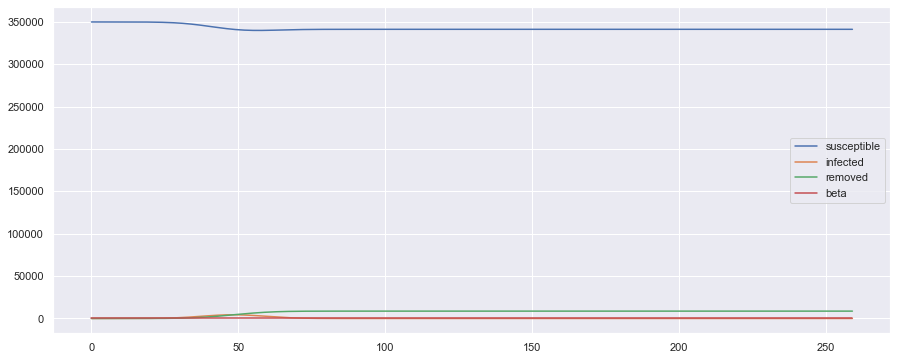

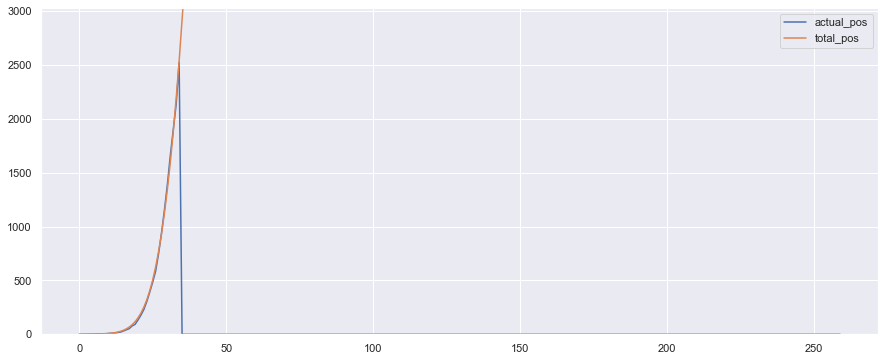

In [11]:
N=350000 
x0 = (0.03434576, 0.78682323, 0.08861404, 2.72153793)  # alpha, beta0, gamma, I0
c = ccd.fit_series/1000
sf = SIR4()
alpha, beta0, gamma, I0 = sf.SIRFitter(c, N, x0)
print("Day 0 = {}  (today={})".format(dfq.date.values[0] - pd.Timedelta(days=ccd.shift),
                            (pd.Timestamp.now() - dfq.date.values[0]).days + ccd.shift))
print("Doubling time (0) is about {:.2f} days".format(np.log(2)/beta0))
print("Alpha = {:.2f}".format(alpha))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))

In [12]:
dfw, wsl = get_dataset_df_from_files()
dfw.head()

,Entity,state,Date,positive,death,daily_new_death,date,last_update,daily_new_positive
0,Afghanistan,AFG,"Dec 31, 2019",0,0,0,2019-12-31,2020-04-07 23:40:20.633414,NaN
1,Afghanistan,AFG,"Jan 1, 2020",0,0,0,2020-01-01,2020-04-07 23:40:20.633414,0.0
2,Afghanistan,AFG,"Jan 2, 2020",0,0,0,2020-01-02,2020-04-07 23:40:20.633414,0.0
3,Afghanistan,AFG,"Jan 3, 2020",0,0,0,2020-01-03,2020-04-07 23:40:20.633414,0.0
4,Afghanistan,AFG,"Jan 4, 2020",0,0,0,2020-01-04,2020-04-07 23:40:20.633414,0.0


/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[ 1.45463555e-03, -3.19869799e-04, -3.25863257e-02],
       [ 3.78229832e-03, -3.01002992e-03, -4.48094142e-01],
       [ 6.10240240e-04, -9.36241405e-05, -1.06414336e-02]])
     fun: 1485959.2062408614
 message: 'Optimization terminated successfully.'
    nfev: 539
     nit: 12
  status: 0
 success: True
       x: array([0.23227977, 0.13952394, 0.17749517])
Day 0 = 2019-12-21 00:00:00  (today=108)
Doubling time is about 2.98 days
Recovery time is about 4.97 days
Estimated initial infection was order of 177 poeple


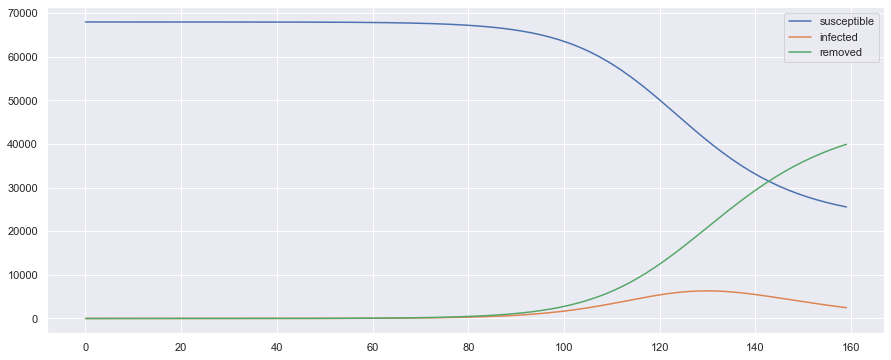

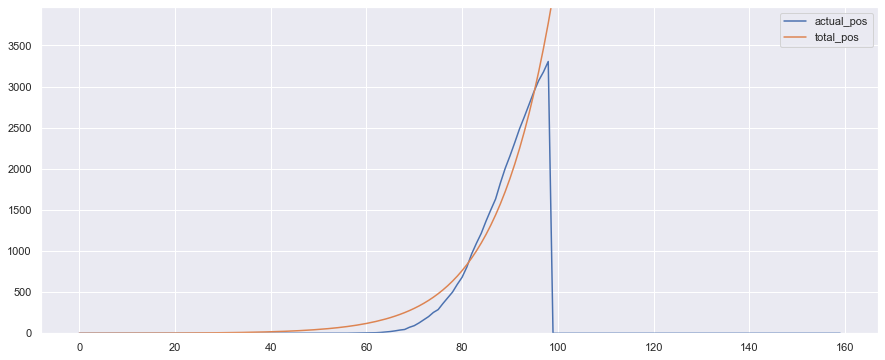

In [13]:
dfq = get_state_df(dfw, "ITA")
ccd = CurrentCasesFromDeaths()
dfq = ccd.add_positive_estimate(dfq)
N=68000 
R0=0
x0 = (0.33989521, 0.14846294, 1.09806025)
c = ccd.fit_series/1000
sf = SIR()
beta, gamma, I0 = sf.SIRFitter(c, N, x0)
print("Day 0 = {}  (today={})".format(dfq.date.values[0] - pd.Timedelta(days=ccd.shift),
                            (pd.Timestamp.now() - dfq.date.values[0]).days + ccd.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[ 1.21773553e-03, -9.26371639e-05, -1.13429080e-03],
       [ 3.39766777e-03, -2.83363306e-03, -4.10313316e-02],
       [ 2.48945869e-04, -1.18716591e-05, -1.69172999e-04]])
     fun: 662710.7980785384
 message: 'Optimization terminated successfully.'
    nfev: 894
     nit: 20
  status: 0
 success: True
       x: array([0.20092435, 0.07372574, 0.00726851])
Day 0 = 2019-12-21 00:00:00  (today=108)
Doubling time is about 3.45 days
Recovery time is about 9.40 days
Estimated initial infection was order of 7 poeple


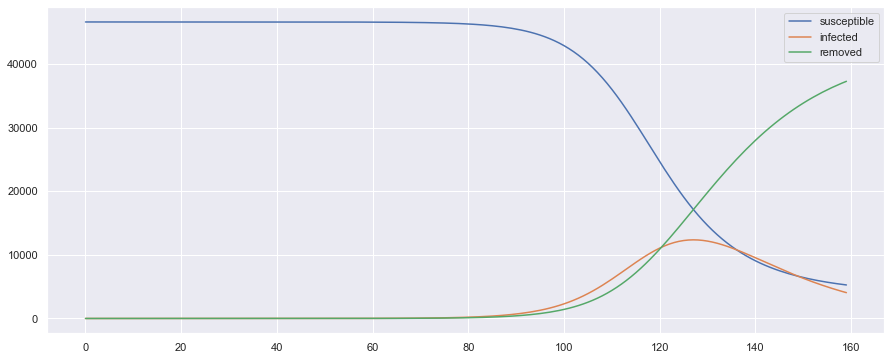

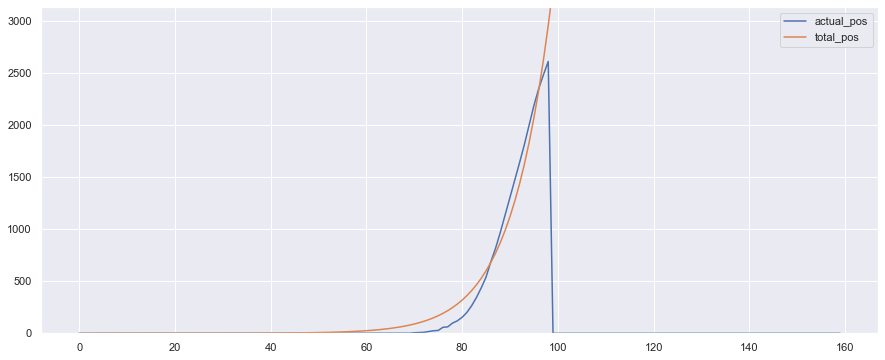

In [14]:
dfq = get_state_df(dfw, "ESP")
ccd = CurrentCasesFromDeaths()
dfq = ccd.add_positive_estimate(dfq)
N=46660 
R0=0
x0 = (0.3896, 0.08149, 0.1)
c = ccd.fit_series/1000
beta, gamma, I0 = sf.SIRFitter(c, N, x0)
print("Day 0 = {}  (today={})".format(dfq.date.values[0] - pd.Timedelta(days=ccd.shift),
                            (pd.Timestamp.now() - dfq.date.values[0]).days + ccd.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))